given a library of midi loops, meander through it, always playing the most similar unplayed loop


In [1]:
midi_metrics = {}

## functions


In [2]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    bar_length = 100
    # decimals = 1
    # percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    percent = f"{iteration:.2f}/{total:.2f}"
    filledLength = int(bar_length * iteration // total)
    bar = fill * filledLength + '-' * (bar_length - filledLength)
    print(f'\r{prefix} |{bar}| {percent} {suffix}', end = printEnd)

    if iteration == total: 
        print()

In [3]:
import pretty_midi

def normalize_midi(mid: pretty_midi.PrettyMIDI):
  """Normalize MIDI file so that the first note is at 0.0s."""
  for instrument in mid.instruments:
    if not instrument.notes:
      continue
    first_note_start = instrument.notes[0].start
    for note in instrument.notes:
      note.start -= first_note_start
      note.end -= first_note_start
  return mid

In [4]:
import pandas as pd
from scipy.spatial.distance import cosine

def build_similarity_table(vectors):
  # Extract names and vectors
  names = [v['name'] for v in vectors]
  vecs = [v['metric'] for v in vectors]

  # Initialize an empty DataFrame
  df = pd.DataFrame(index=names, columns=names, dtype="float64")

  # Compute cosine similarity for each pair of vectors
  for i in range(len(vecs)):
    for j in range(len(vecs)):
      if i != j:
        # Compute cosine similarity and store in DataFrame
        df.iloc[i, j] = 1 - cosine(vecs[i], vecs[j]) # type: ignore
      else:
        # Cosine similarity of a vector with itself is 1
        df.iloc[i, j] = 1

  return df


def get_most_similar_file(filename, different_parent=True):
  n = 1
  similarity = 1
  next_file_played = 1
  next_filename = filename
  midi_metrics[filename]["played"] = 1

  while next_file_played:
    nl = similarity_table.loc[filename].nlargest(n)
    next_filename = nl.index[-1]
    similarity = nl.iloc[-1]
    next_file_played = midi_metrics[next_filename]["played"]
    n += 1

  return next_filename, similarity
    
  
def find_most_similar_vector(target_vector, vector_array):
  most_similar_vector = None
  highest_similarity = -1  # since cosine similarity ranges from -1 to 1

  for vector_data in vector_array:
    name, vector = vector_data.values()
    similarity = 1 - cosine(target_vector, vector)  # type: ignore
    if similarity > highest_similarity:
      highest_similarity = similarity
      most_similar_vector = name

  return most_similar_vector

In [5]:
import mido

def play_midi_file(midi_data: mido.MidiFile, midi_port):
  t = 0
  for msg in midi_data.play():
    printProgressBar(t, midi_data.length, suffix='s')
    t += msg.time # type: ignore
    midi_port.send(msg)
  printProgressBar(midi_data.length, midi_data.length, suffix='s')

In [6]:
def reset_plays():
  for k in midi_metrics.keys():
    midi_metrics[k]["played"] = 0

## calculate metrics


In [7]:
import os
import midi_utils as mu

# src_file = "MIDI2B-TRIMMED"
src_file = "all-time-mini"
folder_path = os.path.join("data", "inputs", src_file)
config = {
  "w1": 0.5, 
  "w2": 0.5, 
  "bin_length": 1.0,
  "ph_weight_dur": False,
  "ph_weight_vel": False
  }

for file in os.listdir(folder_path):
  if file.endswith('.mid') or file.endswith('.midi'):
    file_path = os.path.join(folder_path, file)
    midi = pretty_midi.PrettyMIDI(file_path)
    normalized_midi = normalize_midi(midi)
    metrics = mu.all_metrics(midi, config)
    midi_metrics[file] = {
      "notes": [],# normalized_midi,
      "metrics": metrics,
      "played": 0,
    }

In [8]:
import json

dict_file = os.path.join("data", "outputs", f"{src_file}_metrics.json")

with open(dict_file, 'w') as f:
  json.dump(midi_metrics, f)

In [9]:
all_vecs = [
  {'name': filename, 'metric': details['metrics']['pitch_histogram']}
  for filename, details in midi_metrics.items()
]
similarity_table = build_similarity_table(all_vecs)
print(f"Generated a similarity table of shape {similarity_table.shape}")

Generated a similarity table of shape (10, 10)


## play


In [10]:
import time
import numpy as np
from IPython import display

reset_plays()

# midi settings
midi_device_name = "Disklavier"
# midi_device_name = "to Max 1"
port = mido.open_output(midi_device_name) # type: ignore

# loop settings
loop_chance = 0.0 # 0 to 1
play_time = 6000 # seconds
time_elapsed = 0 # seconds
loop_time = 8 # seconds
similarity = -1

# file system settings
seed = np.random.randint(0, len(midi_metrics.items()) - 1)
current_file_path = list(midi_metrics.items())[seed][0] # choose random initial file
# current_file_path = "MIDI2B-TRIMMED_200-208.mid"
next_file_path = None
playback_record_path = os.path.join("data", "outputs", "logs", f"{int(time.time())}_{src_file}_{seed}.txt")

while (time_elapsed < play_time):
  # mark progress
  midi_metrics[current_file_path]['played'] = 1
  with open(playback_record_path, 'a') as f:
    f.write(current_file_path) # type: ignore
    f.write('\n')

  # find next file
  if (np.random.rand() > loop_chance):
    # cph = list(midi_metrics.items())[seed][1]['metrics']['pitch_histogram']
    # all_vecs = [
    #   {'name': filename, 'metric': details['metrics']['pitch_histogram']}
    #   for filename, details in midi_metrics.items()
    #   if not details['played']
    # ]
    # next_file_path = find_most_similar_vector(cph, all_vecs)
    next_file_path, similarity = get_most_similar_file(current_file_path)
  else:
    next_file_path = current_file_path
  print(f"[{int(time_elapsed):04d}/{play_time:04d}]\tPlaying {current_file_path} \t(next up is {next_file_path})\tsim = {similarity:.3f}")

  # play file
  midi = mido.MidiFile(os.path.join(folder_path, current_file_path)) # type: ignore
  time_elapsed += midi.length
  # display.display(mu.draw_midi(os.path.join(folder_path, current_file_path))) # type: ignore
  play_midi_file(midi, port)
  # display.clear_output(wait=True)

  # move to next file
  current_file_path = next_file_path


OSError: no ports available

## scratch


In [11]:
similarity_table

,20231220-80-5-t_112-120.mid,20231220-80-2-t_184-192.mid,20240121-70-6-t_16-24.mid,20231220-80-2-t_24-32.mid,20240121-70-6-t_64-72.mid,20240121-66-3-t_40-48.mid,20240121-66-3-t_128-136.mid,20240117-64-5-t_8-16.mid,20240117-64-5-t_32-40.mid,20231220-80-5-t_16-24.mid
20231220-80-5-t_112-120.mid,1.000000,0.967965,0.778910,0.939897,0.766715,0.233850,0.255015,0.688623,0.694675,0.972108
20231220-80-2-t_184-192.mid,0.967965,1.000000,0.767264,0.959125,0.761654,0.290628,0.298080,0.556761,0.564508,0.944211
20240121-70-6-t_16-24.mid,0.778910,0.767264,1.000000,0.708402,0.937757,0.236991,0.225802,0.701831,0.730202,0.668059
20231220-80-2-t_24-32.mid,0.939897,0.959125,0.708402,1.000000,0.741110,0.336252,0.362418,0.563951,0.586356,0.942921
20240121-70-6-t_64-72.mid,0.766715,0.761654,0.937757,0.741110,1.000000,0.268989,0.259417,0.618849,0.630433,0.706687
20240121-66-3-t_40-48.mid,0.233850,0.290628,0.236991,0.336252,0.268989,1.000000,0.978280,0.141326,0.186257,0.223125
20240121-66-3-t_128-136.mid,0.255015,0.298080,0.225802,0.362418,0.259417,0.978280,1.000000,0.184644,0.235027,0.243374
20240117-64-5-t_8-16.mid,0.688623,0.556761,0.701831,0.563951,0.618849,0.141326,0.184644,1.000000,0.982225,0.655962
20240117-64-5-t_32-40.mid,0.694675,0.564508,0.730202,0.586356,0.630433,0.186257,0.235027,0.982225,1.000000,0.652925
20231220-80-5-t_16-24.mid,0.972108,0.944211,0.668059,0.942921,0.706687,0.223125,0.243374,0.655962,0.652925,1.000000


In [12]:
from pathlib import Path
for i, row in similarity_table.iterrows():
  most_sim = -1
  most_sim_name = ''
  parent_filename_prim, timeslot_prim = Path(str(i)).stem.split('_')
  # print(parent_filename_prim, timeslot_prim)
  for j, col in row.items():
    parent_filename_sec, timeslot_sec = Path(str(j)).stem.split('_')
    # print(f"\t{parent_filename_sec} - {timeslot_sec} | {col}")
    # if parent_filename_prim == parent_filename_sec:
      # print(f"\t\trejected, same parent")
    # elif col < most_sim:
      # print(f"\t\trejected, {round(col, 2)} < {round(most_sim, 2)}")
    # else:
    if parent_filename_prim != parent_filename_sec and col > most_sim:
      most_sim = col
      most_sim_name = j
  print(f"most similar loop to {i} is {most_sim_name} (s={round(most_sim, 2)})")
    

most similar loop to 20231220-80-5-t_112-120.mid is 20231220-80-2-t_184-192.mid (s=0.97)
most similar loop to 20231220-80-2-t_184-192.mid is 20231220-80-5-t_112-120.mid (s=0.97)
most similar loop to 20240121-70-6-t_16-24.mid is 20231220-80-5-t_112-120.mid (s=0.78)
most similar loop to 20231220-80-2-t_24-32.mid is 20231220-80-5-t_16-24.mid (s=0.94)
most similar loop to 20240121-70-6-t_64-72.mid is 20231220-80-5-t_112-120.mid (s=0.77)
most similar loop to 20240121-66-3-t_40-48.mid is 20231220-80-2-t_24-32.mid (s=0.34)
most similar loop to 20240121-66-3-t_128-136.mid is 20231220-80-2-t_24-32.mid (s=0.36)
most similar loop to 20240117-64-5-t_8-16.mid is 20240121-70-6-t_16-24.mid (s=0.7)
most similar loop to 20240117-64-5-t_32-40.mid is 20240121-70-6-t_16-24.mid (s=0.73)
most similar loop to 20231220-80-5-t_16-24.mid is 20231220-80-2-t_184-192.mid (s=0.94)


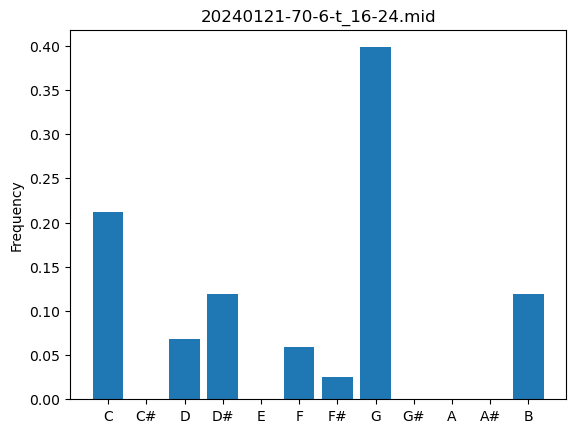

In [13]:
import matplotlib.pyplot as plt

mu.draw_histogram(list(midi_metrics.items())[2][1]['metrics']['pitch_histogram'], list(midi_metrics.items())[2][0])